## Data Extraction


Giacomo Grazia

Final Bachelor Project TU/e & TiU

Academic Year 2024-2025

In [1]:
# imports
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from openai import OpenAI
import ast
import json
import spacy
import locale
from datetime import datetime

nlp = spacy.load("nl_core_news_lg") # Load spaCy model
locale.setlocale(locale.LC_TIME, "nl_NL.UTF-8") # Set locale to Dutch

import os

# Access the OpenAI API key from the environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")

# Use the OpenAI API key
# print(f"OpenAI API Key: {openai_api_key}")

In [2]:
# load the data
df = pd.read_csv('data_date_extraction.csv')

### 0. Preprocessing

In [3]:
# There is  no need to rerun this, preprocessed data is loaded later.

#### 0.a Split based on ground truth availability

In [4]:
print("Total number of rows in 'decision_date':", len(df['decision_date']))
print("Number of missing values in 'decision_date':", df['decision_date'].isna().sum())
print("Number of non-missing values in 'decision_date':", len(df['decision_date']) - df['decision_date'].isna().sum())

Total number of rows in 'decision_date': 359
Number of missing values in 'decision_date': 44
Number of non-missing values in 'decision_date': 315


- **Splitting Data by Ground Truth Availability**: We create two new DataFrames, `df_with_dates` and `df_without_dates`, to separate decisions based on whether they have a valid ground truth date (`decision_date`).

- `df_with_dates`: This DataFrame contains only rows where `decision_date` is available (not `NaT`). We use `.notna()` to filter out missing dates.

- `df_without_dates`: This DataFrame contains only rows where `decision_date` is missing (`NaT`). We use `.isna()` to filter for missing dates.

In [5]:
# DataFrame with valid decision dates (i.e., ground truth available)
df_with_dates = df[df['decision_date'].notna()].copy()

# DataFrame with missing decision dates (i.e., ground truth not available)
df_without_dates = df[df['decision_date'].isna()].copy()

# Display counts of each DataFrame for verification
print("Number of decisions with ground truth date:", len(df_with_dates))
print("Number of decisions without ground truth date:", len(df_without_dates))

Number of decisions with ground truth date: 315
Number of decisions without ground truth date: 44


#### 0.b Extracting dates

- **Set Locale**: We set the locale to Dutch to ensure dates in Dutch format are parsed correctly by Python’s `datetime` module.

- **Date Extraction Function**: The `extract_dates` function (tested above) uses spaCy's NER to identify date entities in the text, and then tries to parse each identified date in formats containing day, month, and year. It appends dates to a list only if they meet the criteria of having all components (day, month, year) and a year that is less than or equal to the current year.

- **Apply Date Extraction**: We apply the `extract_dates` function to a sample of the DataFrame (`df_merged`) to verify extraction accuracy, storing the results in a new column, `dates_NER`.

- **Inspect Extracted Dates**: We display selected columns (`publication_date`, `decision_date`, and `dates_NER`) to confirm that dates are correctly identified and formatted.

In [6]:
def extract_dates(text: str) -> list:
    """
    Extracts dates from the provided text, converting them to datetime objects in yyyy-mm-dd format.
    Only dates with day, month, and year, and where the year is <= current year, are appended.
    Duplicates are removed before returning the list.
    
    :param text: A string containing the text to process.
    :return: A list of unique dates in yyyy-mm-dd format as strings.
    """
    doc = nlp(text)
    dates = set()  # Use a set to automatically handle duplicates -> NO DUPLICATES!
    current_year = datetime.now().year
    
    for ent in doc.ents:
        if ent.label_ == "DATE":
            date_str = ent.text
            date_obj = None
            
            # Try parsing with formats that include day, month, and year
            for fmt in ("%d %B %Y", "%d-%m-%Y"):
                try:
                    # Parse date and check if it includes day, month, and year
                    date_obj = datetime.strptime(date_str, fmt)
                    
                    # Append date only if year is <= current year
                    if date_obj.year <= current_year:
                        dates.add(date_obj.strftime("%Y-%m-%d"))  # Use set to avoid duplicates
                    break  # Exit loop if parsing is successful and criteria met
                except ValueError:
                    continue
            
    return list(dates)  # Convert set back to list before returning

Statistics for NER dates

In [7]:
# Sample DataFrame for testing (use your actual df_merged instead of df_temp)
df_temp = df_with_dates.copy()

# Apply the function to extract and format dates, storing them in a new column
df_temp['dates_NER'] = df_temp['text_pypdf2'].apply(extract_dates)

# Display the DataFrame with the formatted dates
df_temp[['id','publication_date', 'decision_date', 'dates_NER']]

,id,publication_date,decision_date,dates_NER
0,id_acm_energy_permit_0,2024-08-27,2024-08-13,"[2014-05-07, 2024-07-31, 2013-04-02, 2024-08-1..."
1,id_acm_energy_permit_0,2024-08-27,2024-08-13,"[2024-07-31, 2013-04-02, 2024-08-13, 2024-05-0..."
2,id_acm_energy_permit_1,2024-07-23,2024-06-26,"[2024-06-04, 2013-04-02, 2024-06-26, 2010-12-09]"
3,id_acm_energy_permit_1,2024-07-23,2024-06-26,"[2024-06-04, 2007-08-24, 2013-04-02, 2024-06-26]"
4,id_acm_energy_permit_10,2024-04-08,2024-03-27,"[2024-03-27, 2023-10-06, 2013-04-02, 2003-05-0..."
...,...,...,...,...
353,id_acm_energy_permit_94,2018-02-01,2018-01-31,"[2017-10-19, 2017-12-22, 2018-01-25, 2013-04-0..."
354,id_acm_energy_permit_95,2018-01-02,2017-12-21,"[2017-11-06, 2013-04-02, 2017-12-21, 2017-12-1..."
355,id_acm_energy_permit_96,2018-01-02,2017-12-21,"[2017-11-06, 2013-04-02, 2017-12-21, 2017-12-1..."
356,id_acm_energy_permit_97,2017-12-05,2017-11-17,"[2010-06-18, 2013-04-02, 2017-10-16, 2017-11-17]"


In [8]:
df_temp['contains_decision_date'] = df_temp.apply(lambda x: x['decision_date'] in x['dates_NER'], axis=1)
df_temp['contains_decision_date'].sum() / len(df_temp)

0.7714285714285715

In [9]:
df_temp[['id','publication_date', 'decision_date', 'dates_NER']][df_temp['contains_decision_date'] == False].iloc[6]

id                              id_acm_energy_permit_119
publication_date                              2016-08-11
decision_date                                 2016-08-05
dates_NER           [2013-03-13, 2013-04-02, 2003-06-02]
Name: 25, dtype: object

In [10]:
# Create a dictionary with the statistics
stats = {
    "NER dates per decision": ["Median", "Mean", "SD", "Minimum", "Maximum"],
    "Value": [
        df_temp.dates_NER.apply(len).median(),
        df_temp.dates_NER.apply(len).mean(),
        df_temp.dates_NER.apply(len).std(),
        df_temp.dates_NER.apply(len).min(),
        df_temp.dates_NER.apply(len).max()
    ]
}

# Convert the dictionary to a DataFrame
df_stats = pd.DataFrame(stats).round(2)

df_stats

,NER dates per decision,Value
0,Median,7.00
1,Mean,7.49
2,SD,5.39
3,Minimum,1.00
4,Maximum,71.00


#### 0.c Ground truth dates: from str to datetime

In [11]:
df['publication_date'] = pd.to_datetime(df['publication_date'], 
                                               errors='coerce', 
                                               infer_datetime_format=True)

df['decision_date'] = pd.to_datetime(df['decision_date'],
                                            errors='coerce',
                                            infer_datetime_format=True)

/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_11970/3134321660.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['publication_date'] = pd.to_datetime(df['publication_date'],
/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_11970/3134321660.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['decision_date'] = pd.to_datetime(df['decision_date'],


### 1. ML approach

#### 1.1 Date context window

- **Enhanced Date Extraction**: The `extract_date_with_context` function builds upon the previous date extraction method by not only identifying date entities but also capturing their surrounding context.

- **Context Extraction Process**: For each date entity:
  - The function calculates the start and end tokens for the surrounding context based on `context_size`.
  - It constructs a `context_tokens` string by combining words before and after the date, while excluding the date itself, which focuses on surrounding cues rather than the date itself.
  
- **Application**: We apply this function to `df_with_labels`, creating a new column, `date_contexts`, that contains dates along with their contexts for each document.

In [12]:
def extract_date_with_context(text, context_size=10):
    """
    Extracts dates and their surrounding context words from the given text, excluding the date itself.
    
    :param text: The input document as a string.
    :param context_size: The number of words to capture before and after each date.
    :return: A list of dictionaries with each date and its surrounding context. Example: 
    {'date_text': '23 juli 2013', 'context': '.....'}, 

    """
    doc = nlp(text)
    date_contexts = []

    for ent in doc.ents:
        if ent.label_ == "DATE":
            # Get start and end positions of the date in terms of tokens
            start_token = ent.start
            end_token = ent.end
            
            # Capture surrounding words without including the date itself
            start_context = max(0, start_token - context_size)
            end_context = min(len(doc), end_token + context_size)

            # Exclude the date tokens themselves by constructing context only before and after
            context_tokens = doc[start_context:start_token].text + " " + doc[end_token:end_context].text
            
            # Store the date and its context
            date_contexts.append({
                'date_text': ent.text,
                'context': context_tokens
            })
    
    return date_contexts

In [13]:
df_with_dates['date_contexts'] = df_with_dates['text_pypdf2'].apply(extract_date_with_context)

df_without_dates['date_contexts'] = df_without_dates['text_pypdf2'].apply(extract_date_with_context)

In [14]:
df_with_dates.head(1)

,id,file_number,text_pypdf2,headline,description,publication_date,decision_date,case,parties,file_link,party_labeled,decision_category,date_gpt_4o-mini,evaluation_llm,date_contexts
0,id_acm_energy_permit_0,1,ons kenmerk: acm/uit/606179 zaaknummer: acm/23...,Intrekking op eigen verzoek leveringsvergunnin...,De ACM heeft op 13 augustus 2024 namens de Min...,2024-08-27,2024-08-13,ACM/23/185948,TotalEnergies Power & Gas NL,https://www.acm.nl/nl/publicaties/intrekking-o...,TotalEnergies Gas & Power Nederland B.V.,intrekking of beëindiging (revoke/withdraw),2024-08-13,TP,"[{'date_text': '13 augustus 2024', 'context': ..."


In [15]:
df_with_dates.iloc[1].date_contexts[0]

{'date_text': '13 augustus 2024',
 'context': 'ons kenmerk: acm/uit/606177 zaaknummer: acm/23/185948 datum: besluit van de autoriteit consument en markt tot het intrekken'}

#### 1.2 Converting dates into datetime objects

- **Date Parsing Function**: We define `parse_date`, which attempts to convert date strings into `datetime` objects. This function only returns dates that contain day, month, and year components, and where the year is less than or equal to the current year (CONSTRAINTS).

- **Flattening Date Contexts**: We iterate through each row in `df`, applying the following steps:
  - Parse the `decision_date` (ground truth) using `parse_date`.
  - For each identified date in `date_contexts`, parse the date text and compare it to the parsed `decision_date`.
  
- **Identifying Decision Dates**: For each date:
  - We set `is_decision_date` to 1 if the extracted date matches the ground truth `decision_date`, otherwise to 0.

- **Flattening Structure**: Each date along with its context is appended to `flattened_data` as a dictionary containing:
  - `text`: The original document text.
  - `decision_num`: The unique ID for the decision document.
  - `date_text`: The identified date text.
  - `context`: Text surrounding the date.
  - `is_decision_date`: Flag indicating if the date matches the decision date.

- **Create Final DataFrame**: We convert `flattened_data` into a DataFrame (`df_flattened`) for further analysis and model training.


In [16]:
def parse_date(date_text):
    """
    Attempts to parse a date string into a datetime object.
    Only returns a datetime if the date includes day, month, and year, and the year is <= current year.
    
    :param date_text: A string containing the date text.
    :return: A datetime object if conditions are met; otherwise, NaT for datetime fields.
    """
    current_year = datetime.now().year
    
    # If date_text is already a Timestamp, return it directly
    if isinstance(date_text, datetime):
        return date_text
    
    # Try parsing date_text with formats that include day, month, and year
    for fmt in ("%Y-%m-%d", "%d %B %Y", "%d-%m-%Y"):
        try:
            date_obj = datetime.strptime(date_text, fmt)
            # Only return date if it includes a valid day, month, and year <= current year
            if date_obj.year <= current_year:
                return date_obj
        except ValueError:
            continue

    return pd.NaT  # Return NaT if parsing fails or conditions aren't met

# Flatten the date contexts with improved matching and constraints
flattened_data = []
nat_decision_date_count = 0  # Counter for NaT dates in the ground truth

for idx, row in df_with_dates.iterrows():
    decision_date_parsed = parse_date(row['decision_date'])  # Parse ground truth decision date
    
    # Check if the parsed decision date is NaT and update counter
    if pd.isna(decision_date_parsed):
        nat_decision_date_count += 1
    
    for date_info in row['date_contexts']:
        extracted_date_parsed = parse_date(date_info['date_text'])
        
        # Set is_decision_date to 1 if extracted date matches decision date
        is_decision_date = int(extracted_date_parsed == decision_date_parsed) if extracted_date_parsed and decision_date_parsed else 0
        
        # Append data to flattened list
        flattened_data.append({
            'text': row['text_pypdf2'],
            'id': row['id'],
            'date_text': date_info['date_text'],
            'context': date_info['context'],
            'is_decision_date': is_decision_date
        })

# Convert the flattened data to a DataFrame if needed
df_flattened = pd.DataFrame(flattened_data)

# Output the count of NaT decision dates in the ground truth
print("Number of NaT (missing) decision dates in the ground truth:", nat_decision_date_count)

Number of NaT (missing) decision dates in the ground truth: 0


In [17]:
# we can see that we have 367 decision dates
df_flattened['is_decision_date'].value_counts()

is_decision_date
0    9277
1     367
Name: count, dtype: int64

In [18]:
# Filter the DataFrame for rows where is_decision_date is 1
df_decision_dates = df_flattened[df_flattened['is_decision_date'] == 1]

# Check for duplicates based on decision_num and date_text
duplicates = df_decision_dates[df_decision_dates.duplicated(subset=['id', 'date_text'], keep=False)]

# Display the duplicated rows for review
print("Duplicated dates with same decision document ID where is_decision_date is 1:")
duplicates

Duplicated dates with same decision document ID where is_decision_date is 1:


,text,id,date_text,context,is_decision_date
0,ons kenmerk: acm/uit/606179 zaaknummer: acm/23...,id_acm_energy_permit_0,13 augustus 2024,ons kenmerk: acm/uit/606179 zaaknummer: acm/23...,1
13,ons kenmerk: acm/uit/606179 zaaknummer: acm/23...,id_acm_energy_permit_0,13 augustus 2024,"na dagtekening van dit besluit.8 den haag, dat...",1
16,ons kenmerk: acm/uit/606177 zaaknummer: acm/23...,id_acm_energy_permit_0,13 augustus 2024,ons kenmerk: acm/uit/606177 zaaknummer: acm/23...,1
40,ons kenmerk: acm/uit/606177 zaaknummer: acm/23...,id_acm_energy_permit_0,13 augustus 2024,"na dagtekening van dit besluit.8 den haag, dat...",1
45,ons kenmerk: acm/uit/617883 zaaknummer: acm/24...,id_acm_energy_permit_1,26 juni 2024,ons kenmerk: acm/uit/617883 zaaknummer: acm/24...,1
...,...,...,...,...,...
9097,ons kenmerk: acm/uit/496993 zaaknummer: acm/18...,id_acm_energy_permit_81,17 juli 2018,"dag waarop het bekend is gemaakt8. den haag, (...",1
9442,ons kenmerk: acm/uit/450757 zaaknummer: acm/18...,id_acm_energy_permit_90,2 februari 2018,ons kenmerk: acm/uit/450757 zaaknummer: acm/18...,1
9468,ons kenmerk: acm/uit/450757 zaaknummer: acm/18...,id_acm_energy_permit_90,2 februari 2018,de dag waarop het bekend is gemaakt.8 den haag...,1
9491,ons kenmerk: acm/uit/488740 zaaknummer: acm/18...,id_acm_energy_permit_92,9 maart 2018,ons kenmerk: acm/uit/488740 zaaknummer: acm/18...,1


#### 1.3 Classifier comparison

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),  # Linear model for binary classification
    'Decision Tree': DecisionTreeClassifier(random_state=42),  # Non-linear model that splits data into subsets
    'Random Forest': RandomForestClassifier(random_state=42),  # Ensemble method that builds multiple decision trees
    'SVM': SVC(random_state=42, probability=True),             # Classifier that finds the hyperplane separating data into classes
    'Complement NB': ComplementNB(),                           # Variant of Naive Bayes suited for imbalanced data
    'Multinomial NB': MultinomialNB(),                         # Probabilistic classifier for text classification
    # 'Gaussian NB': GaussianNB()                              # Eventually discarded because gaussian-dist. assumption is too strong 
    'K-Nearest Neighbors': KNeighborsClassifier(),             # Non-parametric method classifying based on nearest neighbors
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),             # Ensemble technique building models sequentially
    'AdaBoost': AdaBoostClassifier(random_state=42, algorithm='SAMME'),           # Ensemble method combining weak classifiers
    'Extra Trees': ExtraTreesClassifier(random_state=42)       # Ensemble method building multiple decision trees
}

# Define vectorizers
vectorizers = {
    'TF-IDF_1-gram': TfidfVectorizer(ngram_range=(1,1)), # unigrams only
    'TF-IDF_1,2-gram': TfidfVectorizer(ngram_range=(1,2)), # unigrams and bigrams
    'TF-IDF_1,2,3-gram': TfidfVectorizer(ngram_range=(1,3)), # unigrams, bigrams and trigrams
    'TF-IDF_2-gram': TfidfVectorizer(ngram_range=(2,2)), # bigrams only
    'TF-IDF_3-gram': TfidfVectorizer(ngram_range=(3,3)), # trigrams only
    # binary representations
    'Binary 1-gram BoW': CountVectorizer(ngram_range=(1, 1), binary=True), # unigrams only
    'Binary 2-gram BoW': CountVectorizer(ngram_range=(2, 2), binary=True), # bigrams only
    'Binary 3-gram BoW': CountVectorizer(ngram_range=(3, 3), binary=True), # trigrams only
    'Binary 1,2-gram BoW': CountVectorizer(ngram_range=(1, 2), binary=True), # unigrams and bigrams
    'Binary 1,2,3-gram BoW': CountVectorizer(ngram_range=(1, 3), binary=True), # unigrams, bigrams and trigrams
    # non-binary representations
    '1-gram BoW': CountVectorizer(ngram_range=(1, 1)), # unigrams only
    '2-gram BoW': CountVectorizer(ngram_range=(2, 2)), # bigrams only
    '3-gram BoW': CountVectorizer(ngram_range=(3, 3)), # trigrams only
    '1,2-gram BoW': CountVectorizer(ngram_range=(1, 2)), # unigrams and bigrams
    '1,2,3-gram BoW': CountVectorizer(ngram_range=(1, 3))  # unigrams, bigrams and trigrams
}


from sklearn.metrics import accuracy_score, classification_report

# Create a DataFrame to store results
results = pd.DataFrame(columns=[
    'Vectorizer', 'Classifier', 'Dataset', 
    'Accuracy', 
    'Precision (Class 0)', 'Recall (Class 0)',
    'Precision (Class 1)', 'Recall (Class 1)',
    'Precision (Macro Avg)', 'Recall (Macro Avg)',
    'Precision (Weighted Avg)', 'Recall (Weighted Avg)',
    'F1-score (Macro Avg)', 'F1-score (Weighted Avg)'
])

# Function to add results to the DataFrame
def add_results(vectorizer_name, classifier_name, dataset_type, y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Extract metrics for each class and the averages
    precision_class_0 = report['0']['precision']
    recall_class_0 = report['0']['recall']
    precision_class_1 = report['1']['precision']
    recall_class_1 = report['1']['recall']
    precision_macro_avg = report['macro avg']['precision']
    recall_macro_avg = report['macro avg']['recall']
    precision_weighted_avg = report['weighted avg']['precision']
    recall_weighted_avg = report['weighted avg']['recall']
    f1_score_macro_avg = report['macro avg']['f1-score']
    f1_score_weighted_avg = report['weighted avg']['f1-score']
    
    # Add row to results DataFrame
    results.loc[len(results)] = [
        vectorizer_name, classifier_name, dataset_type,
        accuracy,
        precision_class_0, recall_class_0,
        precision_class_1, recall_class_1,
        precision_macro_avg, recall_macro_avg,
        precision_weighted_avg, recall_weighted_avg,
        f1_score_macro_avg, f1_score_weighted_avg
    ]

# Loop over vectorizers and classifiers
for vec_name, vectorizer in vectorizers.items():
    # print(len(vectorizers))

    # IMBALANCED DATASET ------------------------------------------------------------
  
    # Step 1: Extract unique decision IDs
    unique_ids = df_flattened['id'].unique()
    
    # Step 2: Train-test split on decision IDs
    train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
    
    # Step 3: Create train and test datasets based on IDs
    df_train = df_flattened[df_flattened['id'].isin(train_ids)]
    df_test = df_flattened[df_flattened['id'].isin(test_ids)]
    
    # Vectorize context text for the train and test datasets
    X_context_train = vectorizer.fit_transform(df_train['context'])
    y_train = df_train['is_decision_date']
    
    X_context_test = vectorizer.transform(df_test['context'])
    y_test = df_test['is_decision_date']

    # BALANCED DATASET ------------------------------------------------------------
  
    # Balance the dataset by downsampling
    df_majority = df_train[df_train['is_decision_date'] == 0]
    df_minority = df_train[df_train['is_decision_date'] == 1]

    # Downsample majority class
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    # Create balanced dataset
    df_balanced = pd.concat([df_minority, df_majority_downsampled])

    # get unique ids in new balanced dataset
    unique_ids_2 = df_balanced['id'].unique()

    # split based on unique ids and create new splits
    train_ids_2, test_ids_2 = train_test_split(unique_ids_2, test_size=0.2, random_state=42)
    df_train_balanced = df_balanced[df_balanced['id'].isin(train_ids_2)]
    df_test_balanced = df_balanced[df_balanced['id'].isin(test_ids_2)]

    # Create vectorized X and binary target y
    X_context_train_balanced = vectorizer.fit_transform(df_train_balanced['context'])
    y_train_balanced = df_train_balanced['is_decision_date']
    # print(X_context_train_balanced.shape, y_train_balanced.shape)
    
    X_context_test_balanced = vectorizer.transform(df_test_balanced['context'])
    y_test_balanced = df_test_balanced['is_decision_date']
  
    # Loop over classifiers
    for clf_name, clf in classifiers.items():
        # print(len(classifiers))
        # Train and evaluate on imbalanced dataset
        clf.fit(X_context_train, y_train)
        y_pred_imbalanced = clf.predict(X_context_test)
        add_results(vec_name, clf_name, 'Imbalanced', y_test, y_pred_imbalanced)
        
        # Train and evaluate on balanced dataset
        clf.fit(X_context_train_balanced, y_train_balanced)
        y_pred_balanced = clf.predict(X_context_test_balanced)
        add_results(vec_name, clf_name, 'Balanced', y_test_balanced, y_pred_balanced)

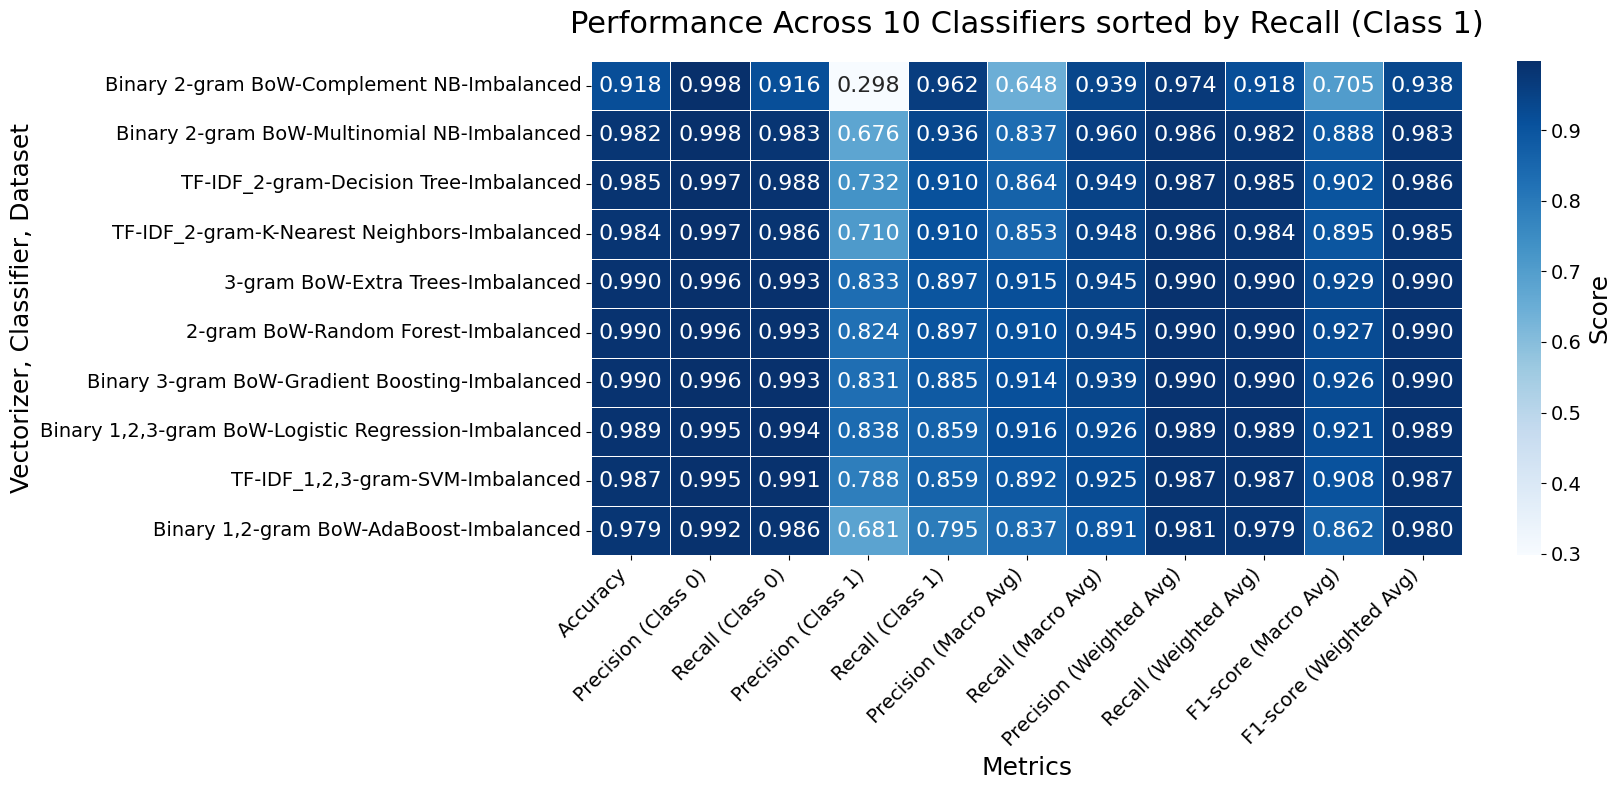

In [21]:
# top 10 imbalanced models by recall class 1
import matplotlib.pyplot as plt
import seaborn as sns


# Filter rows where 'Dataset' is 'Imbalanced'
imbalanced_results = results[results['Dataset'] == 'Imbalanced']

# Get the row with the highest 'Recall (Class 1)' for each 'Classifier'
highest_per_classifier = imbalanced_results.loc[
    imbalanced_results.groupby('Classifier')['Recall (Class 1)'].idxmax()
]
# Sort the resulting rows by 'Recall (Class 1)' in descending order
highest_per_classifier = highest_per_classifier.sort_values(by='Recall (Class 1)', ascending=False)


# Set the 'Vectorizer', 'Classifier', and 'Dataset' columns as an index for clarity
highest_per_classifier = highest_per_classifier.set_index(['Vectorizer', 'Classifier', 'Dataset'])

# Plot the heatmap for the numerical metrics
plt.figure(figsize=(17, 8))  # Increase figure size for larger boxes
heatmap = sns.heatmap(
    highest_per_classifier,
    annot=True,
    cmap='Blues',
    fmt='.3f',
    cbar_kws={'label': 'Score'},  # Label for colorbar
    annot_kws={"size": 16},  # Larger text inside heatmap cells
    square=False,  # Allow rectangular boxes if needed
    linewidths=0.5  # Add spacing between cells for clarity
)

# Increase colorbar tick label size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)  # Increase colorbar tick label size
colorbar.set_label('Score', size=18)  # Increase colorbar label size

# Add titles and labels
plt.title('Performance Across 10 Classifiers sorted by Recall (Class 1)', size=22, pad=20)  # Larger title text
plt.xlabel('Metrics', size=18)  # Larger x-axis label
plt.ylabel('Vectorizer, Classifier, Dataset', size=18)  # Larger y-axis label

# Tilt the x-axis and y-axis labels and increase font size
plt.xticks(rotation=45, ha='right', fontsize=14)  # Larger x-axis tick labels
plt.yticks(rotation=0, fontsize=14)  # Larger y-axis tick labels

# Adjust layout to prevent clipping
plt.tight_layout()

# plt.savefig('/Users/giacomograzia/Downloads/top_10_imb_classifiers_recall_class1.png', dpi=300)

# Display the plot
plt.show()

In [22]:
# statistics for models
results.describe().round(3)

,Accuracy,Precision (Class 0),Recall (Class 0),Precision (Class 1),Recall (Class 1),Precision (Macro Avg),Recall (Macro Avg),Precision (Weighted Avg),Recall (Weighted Avg),F1-score (Macro Avg),F1-score (Weighted Avg)
count,300.000,300.000,300.000,300.000,300.000,300.000,300.000,300.000,300.000,300.000,300.000
mean,0.962,0.975,0.960,0.844,0.888,0.910,0.924,0.965,0.962,0.912,0.963
std,0.029,0.023,0.048,0.128,0.116,0.058,0.053,0.026,0.029,0.058,0.028
min,0.842,0.917,0.725,0.220,0.103,0.608,0.551,0.867,0.842,0.581,0.840
25%,0.947,0.957,0.957,0.798,0.872,0.896,0.919,0.948,0.947,0.902,0.947
50%,0.970,0.984,0.982,0.851,0.916,0.915,0.937,0.970,0.970,0.920,0.970
75%,0.987,0.995,0.992,0.953,0.953,0.948,0.954,0.988,0.987,0.947,0.987
max,0.990,0.998,0.999,0.984,0.984,0.978,0.977,0.990,0.990,0.977,0.990


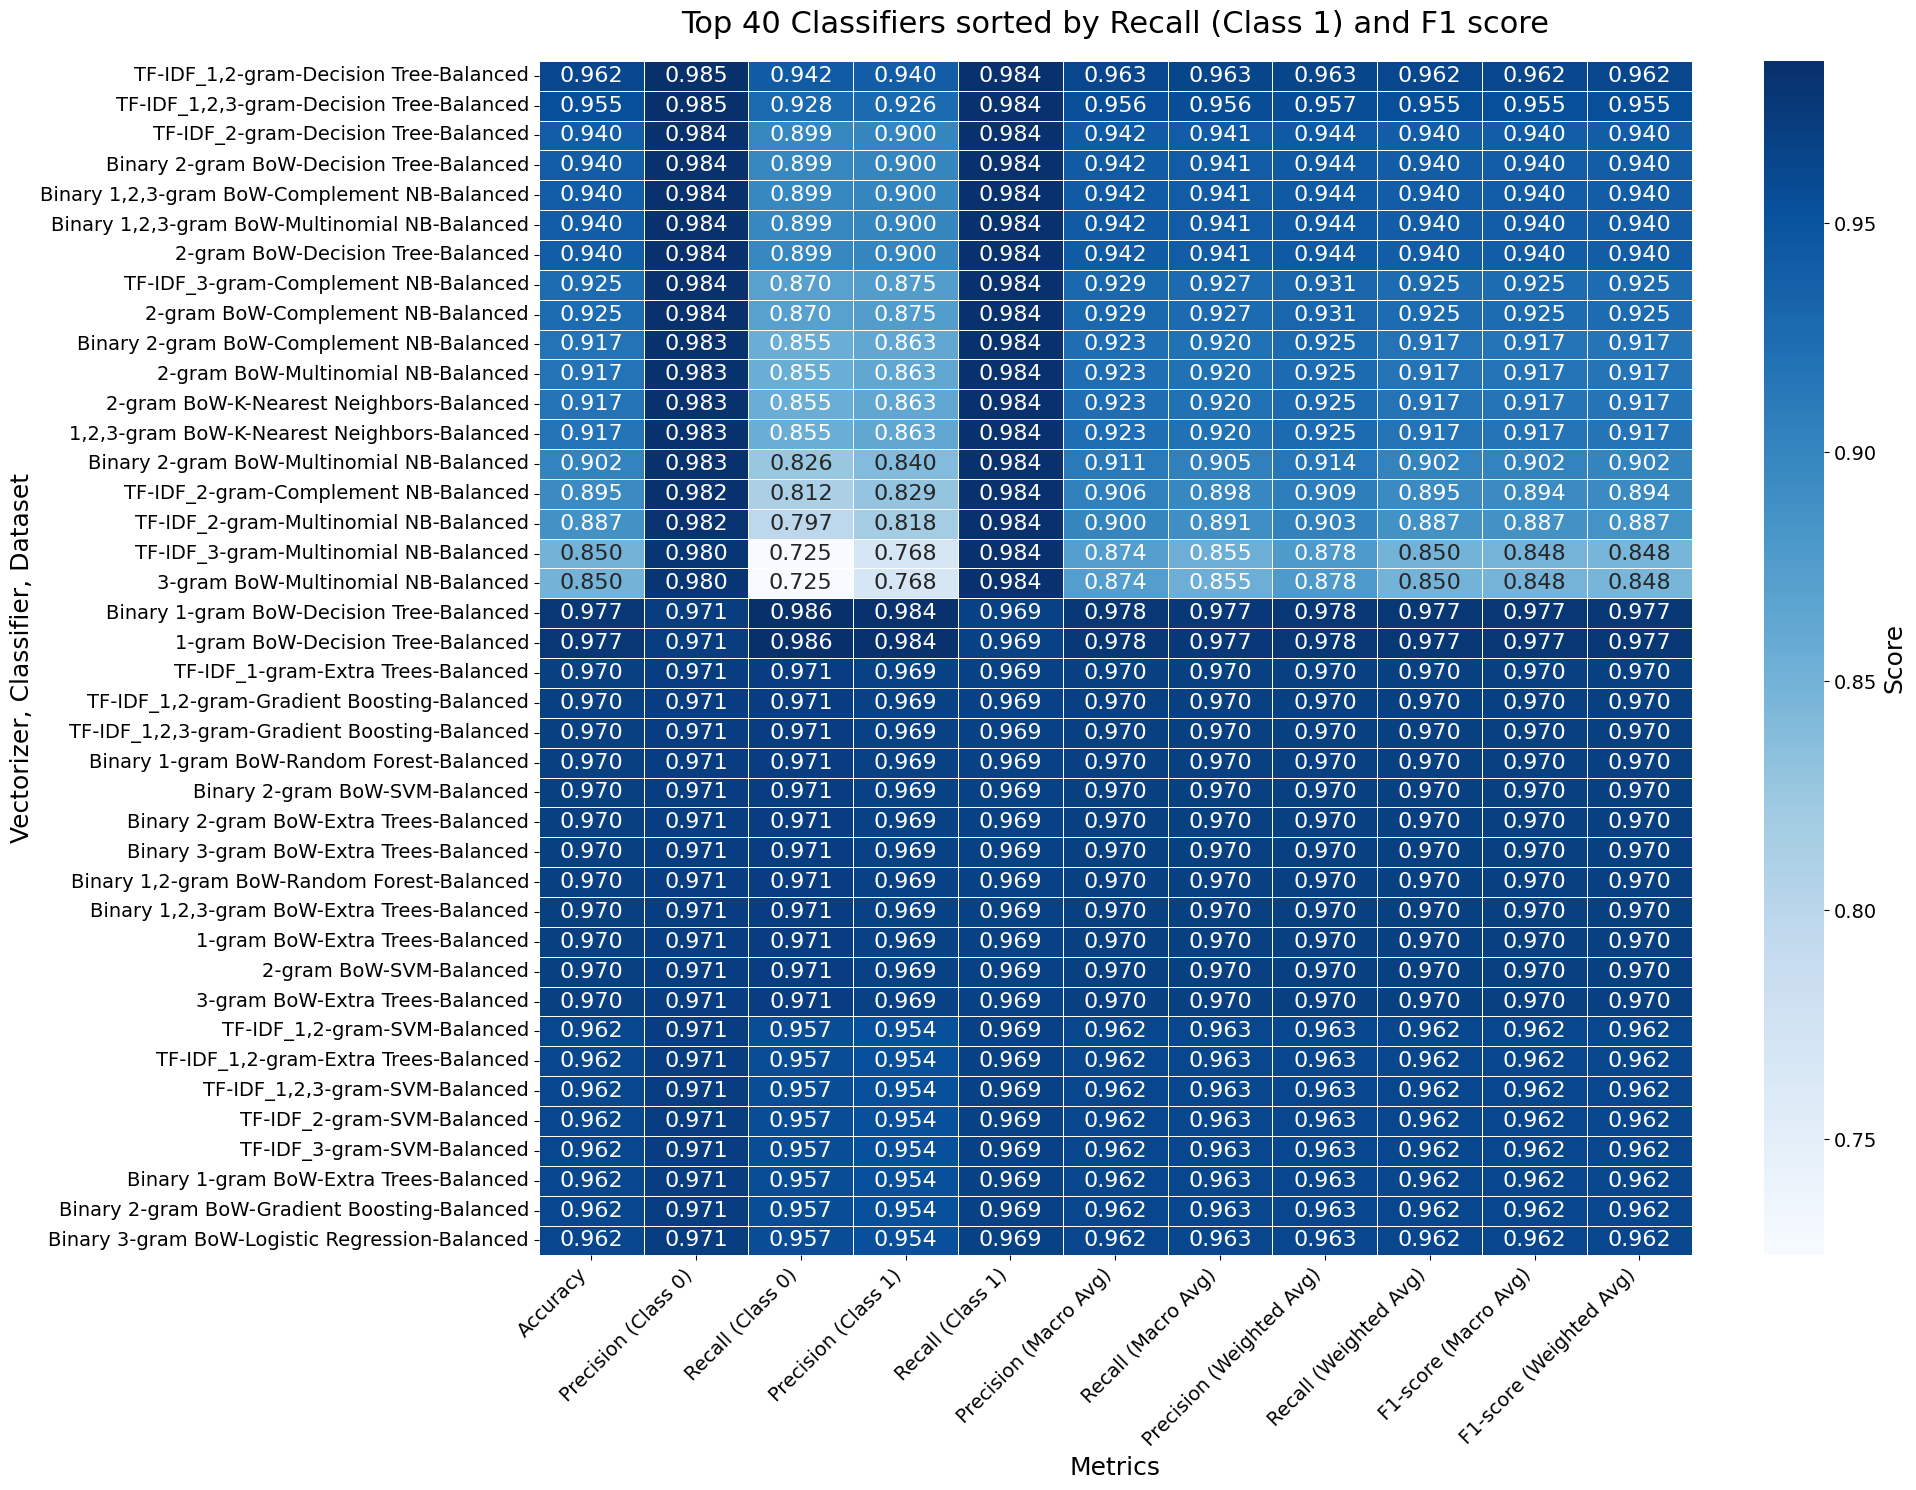

In [23]:
# top 40 classifiers sorted by recall class 1 and f1 score
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by 'Recall (Class 1)' in descending order and select the top 40 rows
top_40_results = results.sort_values(by=['Recall (Class 1)', 'F1-score (Weighted Avg)'], ascending=False).head(40)

# Set the 'Vectorizer', 'Classifier', and 'Dataset' columns as an index for clarity
top_40_results = top_40_results.set_index(['Vectorizer', 'Classifier', 'Dataset'])

# Plot the heatmap for the numerical metrics
plt.figure(figsize=(20, 15))  # Increase figure size for larger boxes
heatmap = sns.heatmap(
    top_40_results,
    annot=True,
    cmap='Blues',
    fmt='.3f',
    cbar_kws={'label': 'Score'},  # Label for colorbar
    annot_kws={"size": 16},  # Larger text inside heatmap cells
    square=False,  # Allow rectangular boxes if needed
    linewidths=0.5  # Add spacing between cells for clarity
)

# Increase colorbar tick label size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)  # Increase colorbar tick label size
colorbar.set_label('Score', size=18)  # Increase colorbar label size

# Add titles and labels
plt.title('Top 40 Classifiers sorted by Recall (Class 1) and F1 score', size=22, pad=20)  # Larger title text
plt.xlabel('Metrics', size=18)  # Larger x-axis label
plt.ylabel('Vectorizer, Classifier, Dataset', size=18)  # Larger y-axis label

# Tilt the x-axis and y-axis labels and increase font size
plt.xticks(rotation=45, ha='right', fontsize=14)  # Larger x-axis tick labels
plt.yticks(rotation=0, fontsize=14)  # Larger y-axis tick labels

# Adjust layout to prevent clipping
plt.tight_layout()

# plt.savefig('/Users/giacomograzia/Downloads/top_40_classifiers_recall_class1.png', dpi=300)

# Display the plot
plt.show()


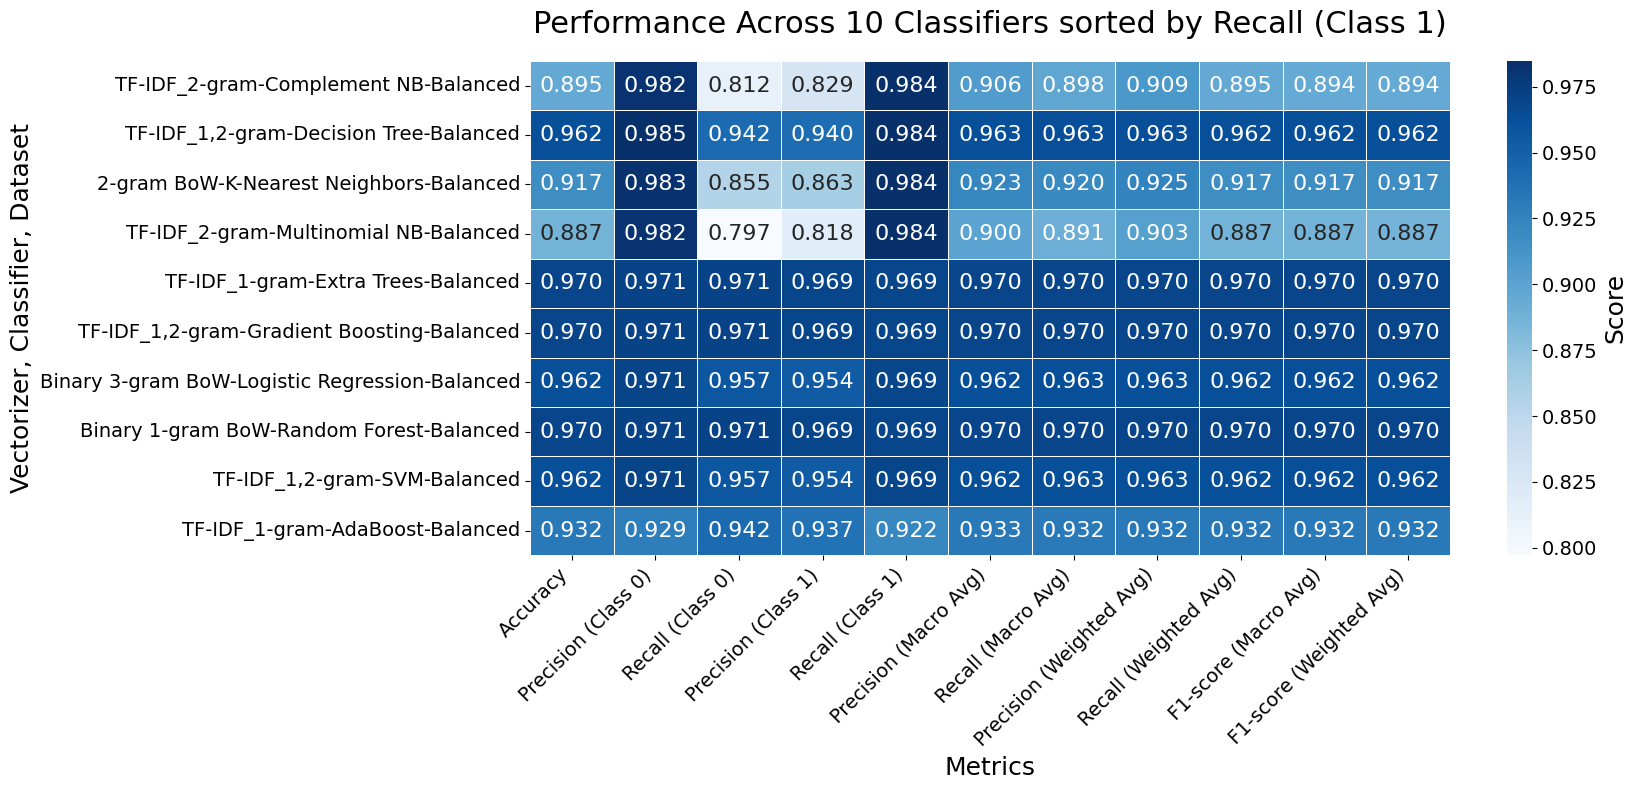

In [24]:
# top 10 models by recall class 1
import seaborn as sns
import matplotlib.pyplot as plt

# Get best 10 classifiers based on Recall (Class 1)
top_classifiers = results.loc[results.groupby('Classifier')['Recall (Class 1)'].idxmax()].sort_values(by='Recall (Class 1)', ascending=False)

# Set the 'Vectorizer', 'Classifier', and 'Dataset' columns as an index for clarity
top_classifiers = top_classifiers.set_index(['Vectorizer', 'Classifier', 'Dataset'])

# Plot the heatmap for the numerical metrics
plt.figure(figsize=(17, 8))  # Increase figure size for larger boxes
heatmap = sns.heatmap(
    top_classifiers,
    annot=True,
    cmap='Blues',
    fmt='.3f',
    cbar_kws={'label': 'Score'},  # Label for colorbar
    annot_kws={"size": 16},  # Larger text inside heatmap cells
    square=False,  # Allow rectangular boxes if needed
    linewidths=0.5  # Add spacing between cells for clarity
)

# Increase colorbar tick label size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)  # Increase colorbar tick label size
colorbar.set_label('Score', size=18)  # Increase colorbar label size

# Add titles and labels
plt.title('Performance Across 10 Classifiers sorted by Recall (Class 1)', size=22, pad=20)  # Larger title text
plt.xlabel('Metrics', size=18)  # Larger x-axis label
plt.ylabel('Vectorizer, Classifier, Dataset', size=18)  # Larger y-axis label

# Tilt the x-axis and y-axis labels and increase font size
plt.xticks(rotation=45, ha='right', fontsize=14)  # Larger x-axis tick labels
plt.yticks(rotation=0, fontsize=14)  # Larger y-axis tick labels

# Adjust layout to prevent clipping
plt.tight_layout()

# plt.savefig('/Users/giacomograzia/Downloads/top_10_classifiers_recall_class1.png', dpi=300)

# Display the plot
plt.show()


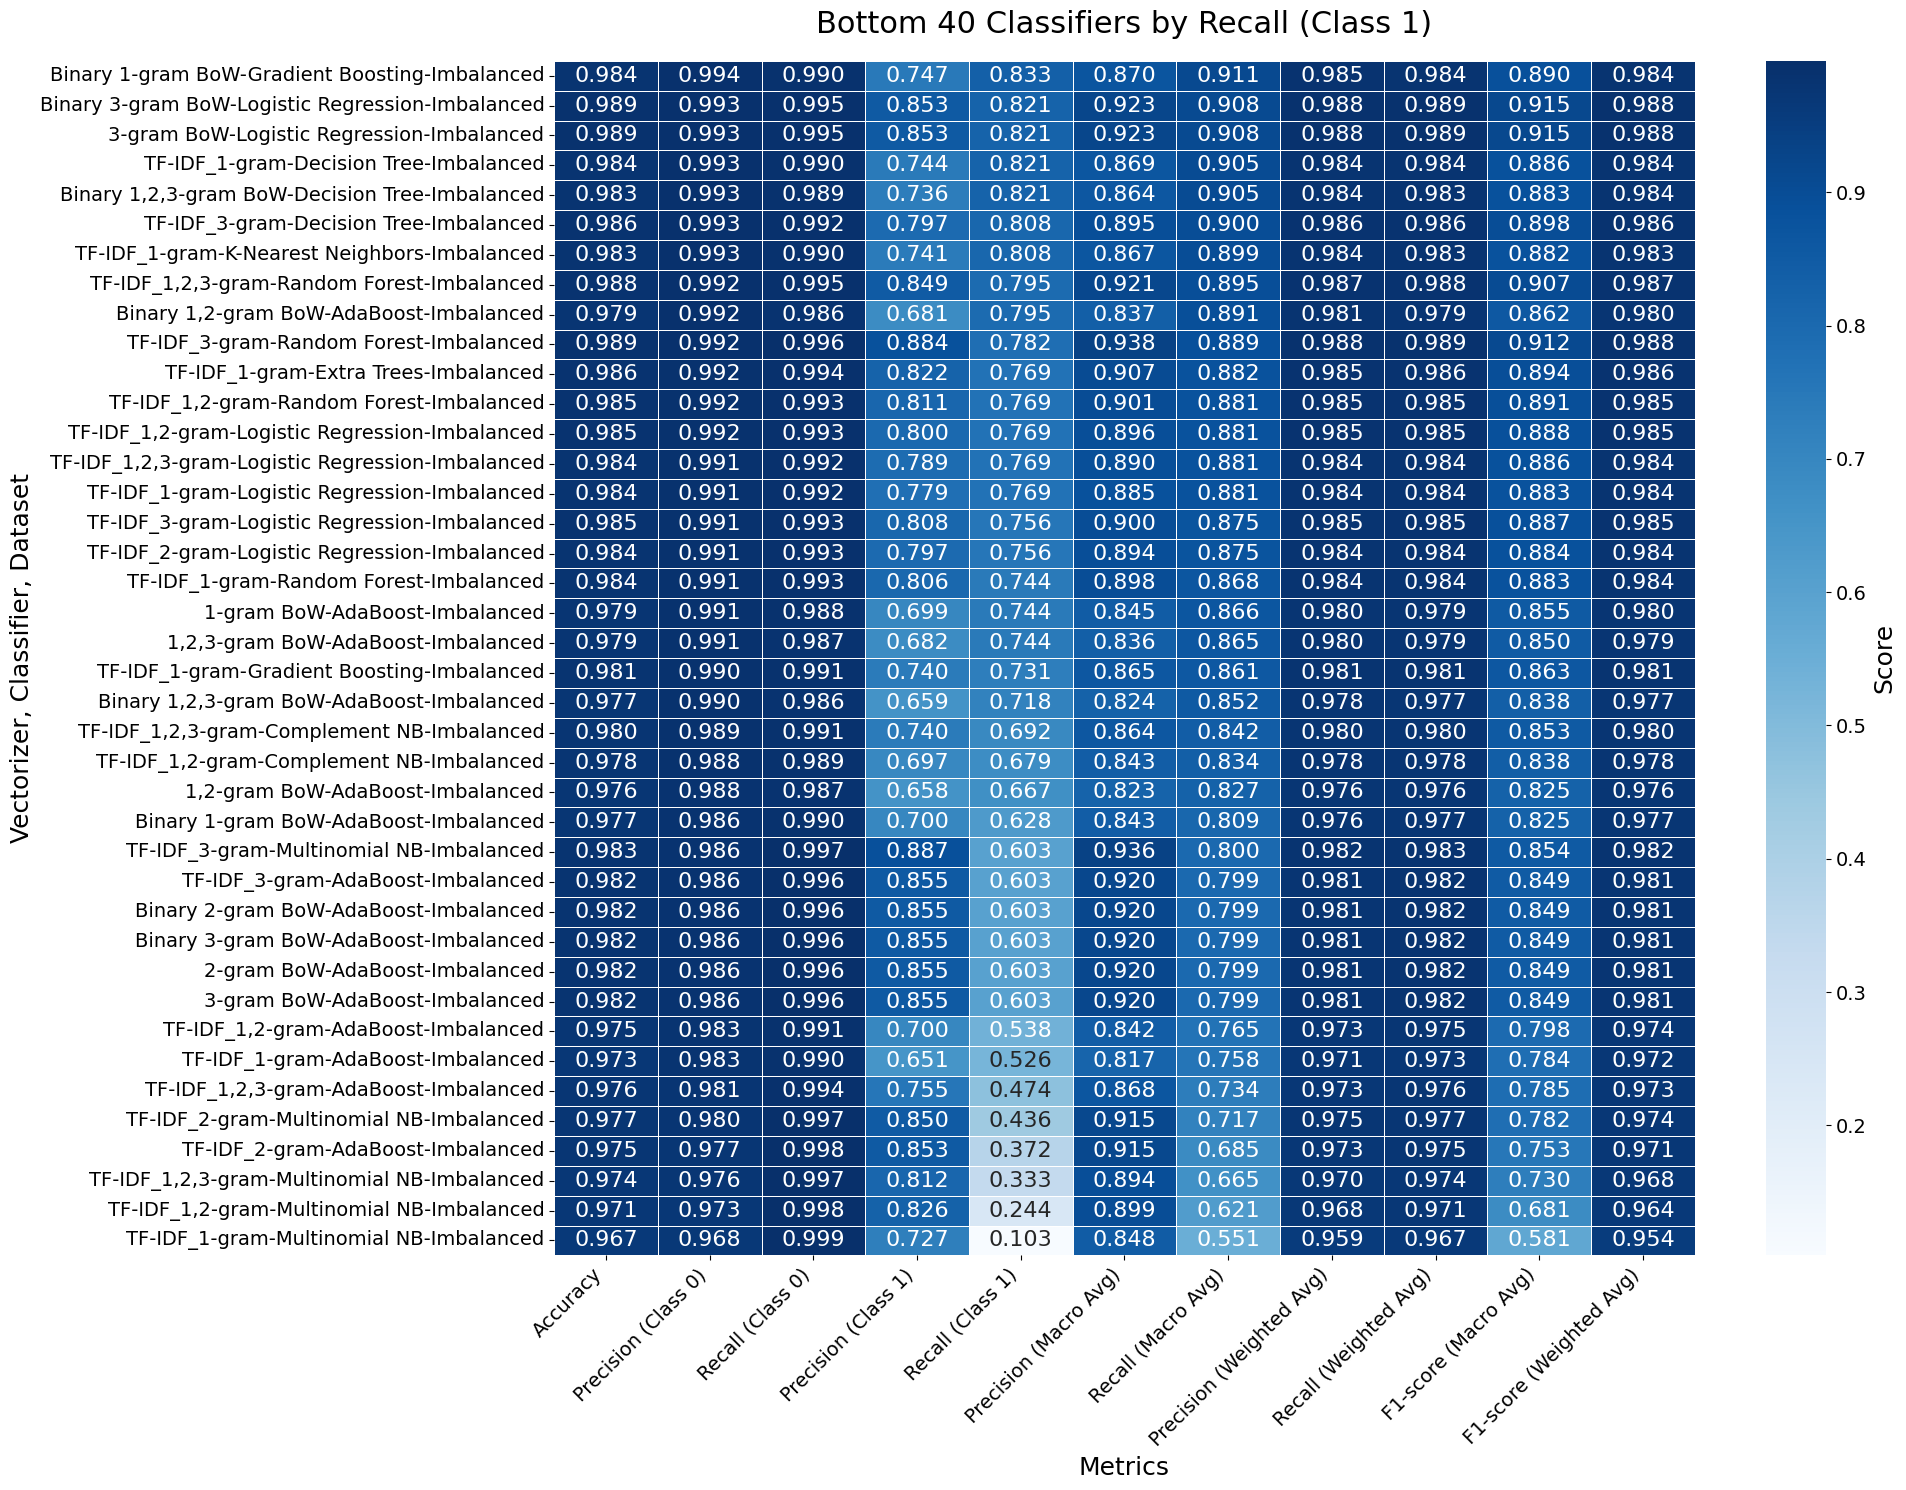

In [25]:
# bottom 40 classifiers by recall class 1
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by 'Recall (Class 1)' in descending order and select the top 40 rows
top_40_results = results.sort_values(by=['Recall (Class 1)', 'F1-score (Weighted Avg)'], ascending=False).tail(40).round(8)

# Set the 'Vectorizer', 'Classifier', and 'Dataset' columns as an index for clarity
top_40_results = top_40_results.set_index(['Vectorizer', 'Classifier', 'Dataset'])

# Plot the heatmap for the numerical metrics
plt.figure(figsize=(20, 15))  # Increase figure size for larger boxes
heatmap = sns.heatmap(
    top_40_results,
    annot=True,
    cmap='Blues',
    fmt='.3f',
    cbar_kws={'label': 'Score'},  # Label for colorbar
    annot_kws={"size": 16},  # Larger text inside heatmap cells
    square=False,  # Allow rectangular boxes if needed
    linewidths=0.5  # Add spacing between cells for clarity
)

# Increase colorbar tick label size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)  # Increase colorbar tick label size
colorbar.set_label('Score', size=18)  # Increase colorbar label size

# Add titles and labels
plt.title('Bottom 40 Classifiers by Recall (Class 1)', size=22, pad=20)  # Larger title text
plt.xlabel('Metrics', size=18)  # Larger x-axis label
plt.ylabel('Vectorizer, Classifier, Dataset', size=18)  # Larger y-axis label

# Tilt the x-axis and y-axis labels and increase font size
plt.xticks(rotation=45, ha='right', fontsize=14)  # Larger x-axis tick labels
plt.yticks(rotation=0, fontsize=14)  # Larger y-axis tick labels

# Adjust layout to prevent clipping
plt.tight_layout()

# plt.savefig('/Users/giacomograzia/Downloads/bottom_40_classifiers_recall_class1.png', dpi=300)

# Display the plot
plt.show()


#### 1.4 Fine tuning (Logistic Regression)

In [26]:
# Use same balanced data from training
X_train = df_train_balanced.context
y_train = df_train_balanced.is_decision_date

X_test = df_test_balanced.context
y_test = df_test_balanced.is_decision_date


# Vectorize
tfidf = TfidfVectorizer(ngram_range=(1,1)) # unigrams only
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Train a Logistic Regression classifier
clf = LogisticRegression(random_state=42, max_iter=int(1e5), class_weight=None)
clf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame for better formatting
report_df = pd.DataFrame(report_dict).transpose()

# Round to 3 decimal places
report_df = report_df.round(3)

# Display the formatted classification report
print('\n',report_df)

Accuracy: 0.924812030075188

               precision  recall  f1-score  support
0                 0.928   0.928     0.928   69.000
1                 0.922   0.922     0.922   64.000
accuracy          0.925   0.925     0.925    0.925
macro avg         0.925   0.925     0.925  133.000
weighted avg      0.925   0.925     0.925  133.000


In [27]:
# FINE TUNING, BALANCED LOG REG -- consider adding AUC/ROC

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],         # Regularization strength
    'solver': ['liblinear', 'saga'],      # Solver to use for optimization
    'penalty': ['l1', 'l2'],}              # Regularization penalty}

# Initialize the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=int(1e5), 
                             class_weight=None) # {0: 0.45, 1: 0.65}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, 
                           param_grid=param_grid, 
                           cv=5, scoring='f1_weighted', 
                           refit=True, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_pred_best = best_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_best, output_dict=True)

# Convert to DataFrame for better formatting
report_df = pd.DataFrame(report_dict).transpose()

# Round to 3 decimal places
report_df = report_df.round(3)

# Display the formatted classification report
print('\n',report_df)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Tuned Model Accuracy: 0.9699248120300752

               precision  recall  f1-score  support
0                 0.971   0.971     0.971    69.00
1                 0.969   0.969     0.969    64.00
accuracy          0.970   0.970     0.970     0.97
macro avg         0.970   0.970     0.970   133.00
weighted avg      0.970   0.970     0.970   133.00


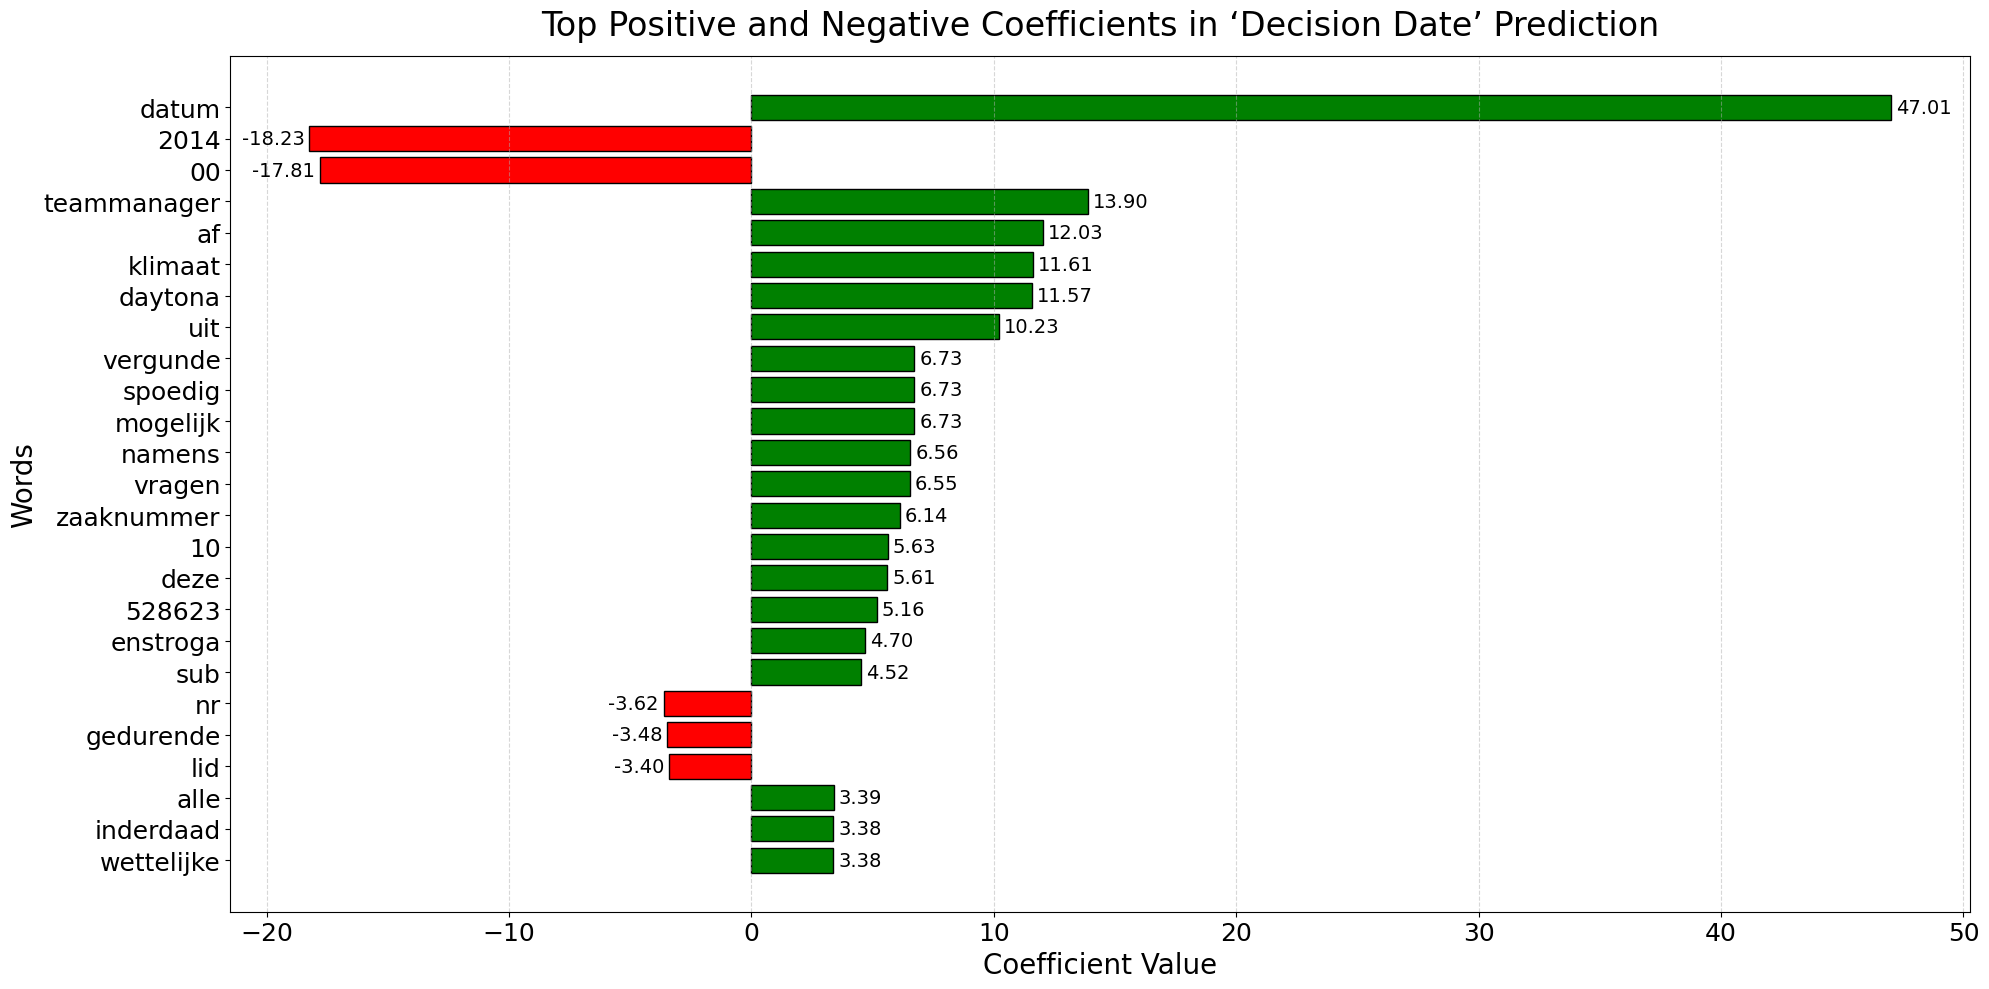

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Extract coefficients from the best-performing logistic regression model
coefficients = grid_search.best_estimator_.coef_[0]

# Create a DataFrame with words and their corresponding coefficients
feature_importance = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

# Sort by the absolute value of the coefficient to find the most important words
top_features = feature_importance.reindex(feature_importance.coefficient.abs().sort_values(ascending=False).index)

# Select top positive
top_positive_features = top_features.head(25)  # Top 25 positive

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))

# Color positive and negative coefficients differently
colors = ['green' if coef > 0 else 'red' for coef in top_positive_features['coefficient']]

ax.barh(
    top_positive_features['word'], 
    top_positive_features['coefficient'], 
    color=colors, 
    edgecolor='black'
)
ax.set_xlabel("Coefficient Value", fontsize=20)
ax.set_ylabel("Words", fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_title("Top Positive and Negative Coefficients in ‘Decision Date’ Prediction", fontsize=24, pad=15)
ax.invert_yaxis()

# Add grid lines for readability
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Annotate the bars with their exact values
for i, (word, coef) in enumerate(zip(top_positive_features['word'], top_positive_features['coefficient'])):
    ax.text(
        coef + (0.2 if coef > 0 else -0.2),  # Increased offset for padding
        i, 
        f"{coef:.2f}", 
        fontsize=14,
        va='center',
        ha='left' if coef > 0 else 'right',
        color='black'
        )


plt.tight_layout()

# plt.savefig('/Users/giacomograzia/Downloads/top_25_features_log_reg_date.png', dpi=300)

plt.show()


#### 1.5 Predicting missing dates

In [29]:
print(df_without_dates.id.unique())
print(len(df_without_dates.id.unique()))

['id_acm_energy_permit_100' 'id_acm_energy_permit_166'
 'id_acm_energy_permit_191' 'id_acm_energy_permit_227'
 'id_acm_energy_permit_228' 'id_acm_energy_permit_245'
 'id_acm_energy_permit_246' 'id_acm_energy_permit_253'
 'id_acm_energy_permit_254' 'id_acm_energy_permit_259'
 'id_acm_energy_permit_29' 'id_acm_energy_permit_298'
 'id_acm_energy_permit_45' 'id_acm_energy_permit_52'
 'id_acm_energy_permit_55' 'id_acm_energy_permit_58'
 'id_acm_energy_permit_72' 'id_acm_energy_permit_75'
 'id_acm_energy_permit_98']
19


In [30]:
import pandas as pd

# Define the threshold for prediction likelihood
threshold = 0

# Initialize dictionary to store predictions for each document
predictions_by_document = {}

# Process each document without a decision date -> df_without_dates which has more than one row per document
for idx, row in df_without_dates.iterrows():
    # Extract date contexts
    dates_with_context = extract_date_with_context(row['text_pypdf2'], context_size=20)

    # Store all dates above the threshold for the current document
    document_predictions = []
    
    for date in dates_with_context:
        # Vectorize the context of the date
        context_vectorized = tfidf.transform([date['context']])
        
        # Get probabilities for the prediction
        probabilities = best_model.predict_proba(context_vectorized)[0]
        decision_likelihood = probabilities[1]  # Probability of class 1 (is_decision_date)
        
        # Store the date if likelihood exceeds the threshold
        if decision_likelihood >= threshold and len(document_predictions) < 2:
            parsed_date = parse_date(date['date_text'])  # Parse the predicted date
            
            # Check if the parsed date is not NaT
            if not pd.isna(parsed_date):
                document_predictions.append({
                    'predicted_date': parsed_date.strftime('%Y-%m-%d'),  # Store in yyyy-mm-dd format
                    'likelihood': decision_likelihood,
                    'context': date['context'],
                    'text': row['text_pypdf2']
                })
    
    # Add predictions and raw text to the dictionary for the current document
    if document_predictions:
        predictions_by_document[row['id']] = {
            'text_pypdf2': row['text_pypdf2'],  # Include the original text
            'predictions': document_predictions
        }

In [31]:
# Convert predictions_by_document to the desired format
rows = []
for doc_id, data in predictions_by_document.items():
    predictions = data['predictions']
    
    # Sort predictions by likelihood in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x['likelihood'], reverse=True)
    
    # Extract sorted dates and likelihoods
    sorted_dates = [pred['predicted_date'] for pred in sorted_predictions]
    sorted_likelihoods = [pred['likelihood'] for pred in sorted_predictions]
    sorted_contexts = [pred['context'] for pred in sorted_predictions]
    
    # Append the data to rows
    rows.append({
        'Document ID': doc_id,
        'Predicted Dates': sorted_dates,
        'Likelihoods': sorted_likelihoods,
        'Contexts': sorted_contexts,
        'Text': data['text_pypdf2']  # Use the original text from the data dictionary
    })

# Create the DataFrame
df_predictions = pd.DataFrame(rows)

# Display the DataFrame
df_predictions = df_predictions.sort_values(
    by='Likelihoods', 
    ascending=False, 
    key=lambda x: x.apply(lambda y: y[0])
)
df_predictions

,Document ID,Predicted Dates,Likelihoods,Contexts,Text
14,id_acm_energy_permit_55,"[2019-06-27, 2019-06-27]","[0.9993733106859751, 0.0007115948089789233]",[ons kenmerk: acm/uit/513956 zaaknummer: acm/1...,ons kenmerk: acm/uit/513956 zaaknummer: acm/19...
17,id_acm_energy_permit_75,"[2018-10-15, 2003-05-08]","[0.9975946626667925, 0.0015357588652155016]",[ons kenmerk: acm/uit/500183 zaaknummer: acm/1...,ons kenmerk: acm/uit/500183 zaaknummer: acm/18...
16,id_acm_energy_permit_72,"[2018-10-23, 2018-10-15]","[0.9916867741583935, 0.024035358612450854]",[ons kenmerk: acm/uit/500635 zaaknummer: acm/1...,ons kenmerk: acm/uit/500635 zaaknummer: acm/18...
10,id_acm_energy_permit_29,"[2020-03-19, 2004-06-02]","[0.985824192457745, 0.06070227673923399]",[ons kenmerk: acm/uit/530899 zaaknummer: acm/2...,ons kenmerk: acm/uit/530899 zaaknummer: acm/20...
15,id_acm_energy_permit_58,"[2019-03-13, 2019-02-04]","[0.9808481370430163, 0.015760362683263102]",[ons kenmerk: acm/uit/508793 zaaknummer: acm/1...,ons kenmerk: acm/uit/508793 zaaknummer: acm/19...
13,id_acm_energy_permit_52,"[2019-07-11, 2019-02-27]","[0.966038749607602, 0.01496348985147476]",[ons kenmerk: acm/uit/515198 zaaknummer: acm/1...,ons kenmerk: acm/uit/515198 zaaknummer: acm/19...
18,id_acm_energy_permit_98,"[2017-10-30, 2014-02-06]","[0.9029665878702735, 1.140943374064181e-05]",[van flexenergie b.v. voor de levering van ele...,acm/uit/314221 muzenstraat 41 www.acm.nl 2511 ...
11,id_acm_energy_permit_298,"[2020-01-14, 2020-09-15]","[0.26467497438215215, 0.024423656005460398]",[artikel 12c van de gaswet. autoriteit consume...,ons kenmerk: acm/uit/546823 contactpersoon: [v...
12,id_acm_energy_permit_45,"[2018-11-26, 2018-12-04]","[0.0632067426815599, 0.0444379898238876]",[autoriteit consument & markt openbaar zaaknr....,ons kenmerk: acm/uit/520075 zaaknummer: acm/18...
0,id_acm_energy_permit_100,"[2006-09-15, 2013-07-23]","[0.05094568223422574, 0.01309877146335884]",[de vergunning van energie der nederlanden voo...,acm/uit/177356 zaaknummer: acm/17/005977 beslu...


In [ ]:
# df_predictions.to_csv('/Users/giacomograzia/Downloads/date_prediction_inspection.csv', index=False, sep=',')

### 2. LLM-based approach

In [32]:
df_with_dates['date_list'] = df_with_dates['text_pypdf2'].apply(extract_dates)

In [33]:
df_with_dates.head()

,id,file_number,text_pypdf2,headline,description,publication_date,decision_date,case,parties,file_link,party_labeled,decision_category,date_gpt_4o-mini,evaluation_llm,date_contexts,date_list
0,id_acm_energy_permit_0,1,ons kenmerk: acm/uit/606179 zaaknummer: acm/23...,Intrekking op eigen verzoek leveringsvergunnin...,De ACM heeft op 13 augustus 2024 namens de Min...,2024-08-27,2024-08-13,ACM/23/185948,TotalEnergies Power & Gas NL,https://www.acm.nl/nl/publicaties/intrekking-o...,TotalEnergies Gas & Power Nederland B.V.,intrekking of beëindiging (revoke/withdraw),2024-08-13,TP,"[{'date_text': '13 augustus 2024', 'context': ...","[2014-05-07, 2024-07-31, 2013-04-02, 2024-08-1..."
1,id_acm_energy_permit_0,2,ons kenmerk: acm/uit/606177 zaaknummer: acm/23...,Intrekking op eigen verzoek leveringsvergunnin...,De ACM heeft op 13 augustus 2024 namens de Min...,2024-08-27,2024-08-13,ACM/23/185948,TotalEnergies Power & Gas NL,https://www.acm.nl/nl/publicaties/intrekking-o...,TotalEnergies Gas & Power Nederland B.V.,intrekking of beëindiging (revoke/withdraw),2024-08-13,TP,"[{'date_text': '13 augustus 2024', 'context': ...","[2024-07-31, 2013-04-02, 2024-08-13, 2024-05-0..."
2,id_acm_energy_permit_1,1,ons kenmerk: acm/uit/617883 zaaknummer: acm/24...,Intrekking leveringsvergunningen elektriciteit...,De ACM heeft de leveringsvergunningen van HVC ...,2024-07-23,2024-06-26,ACM/24/188910,De Vrije Energie Producent B.V. Qwint B.V,https://www.acm.nl/nl/publicaties/intrekking-l...,HVC Energie B.V.,intrekking of beëindiging (revoke/withdraw),2024-06-26,TP,"[{'date_text': '26 juni 2024', 'context': 'ons...","[2024-06-04, 2013-04-02, 2024-06-26, 2010-12-09]"
3,id_acm_energy_permit_1,2,ons kenmerk: acm/uit/617882 zaaknummer: acm/24...,Intrekking leveringsvergunningen elektriciteit...,De ACM heeft de leveringsvergunningen van HVC ...,2024-07-23,2024-06-26,ACM/24/188910,De Vrije Energie Producent B.V. Qwint B.V,https://www.acm.nl/nl/publicaties/intrekking-l...,HVC Energie B.V.,intrekking of beëindiging (revoke/withdraw),NaN,FN,"[{'date_text': '26 juni 2024', 'context': 'ons...","[2024-06-04, 2007-08-24, 2013-04-02, 2024-06-26]"
4,id_acm_energy_permit_10,1,ons kenmerk: acm/uit/618385 zaaknummer: acm/23...,Vergunning elektriciteit Youfone Energie komt ...,De energievergunning van Youfone Energie B.V. ...,2024-04-08,2024-03-27,NaN,NaN,https://www.acm.nl/nl/publicaties/vergunning-e...,"Youfone Energie B.V., DigiWatt Energie B.V.",wijziging of aanpassen (amend/modify),2024-03-27,TP,"[{'date_text': '27 maart 2024', 'context': 'on...","[2024-03-27, 2023-10-06, 2013-04-02, 2003-05-0..."


**NOTE**: do not rerun this first cell. The OpenAI API outputs are already stored in the loaded dataset.

In [78]:
# Function to preprocess each row and call the OpenAI API for categorization
def predict_date_openai(row):
    """
    Processes a row to extract the decision date included in the text, if any.

    :param row: A row from the DataFrame containing the text to analyze.
    :return: predicted date, as datetime object, if found; otherwise, NaT.
    """
    decision_text = row.get("text_pypdf2", "")

    prompt = f"""
    You are given the following text. Your task is to determine if it is an administrative decision 
    and, if so, extract the decision issuance date. Strictly follow these guidelines:

        1. Identify if the text is an administrative decision or not (it could be a public announcement for instance).
        2. Extract the decision issuance date if available. Ignore irrelevant dates (e.g., dates mentioned in the text but not related to the decision issuance—e.g. law dates).
        3. Do not predict a date based on other elements like laws and regulations.
        4. Verify the identified date exists in the text (reverse look it up) and then ensure it is indeed the decision date.

    Given the following text, analyze it and determine if it is an administrative decision.
    If so, output the decision issuance date, if available. Most decision texts contain multiple dates,
    with some of them being irrelevant (for example, dates mentioned in the text but not related to 
    the date on which the decision was issued). If no date is found, don't try to predict it based on other
    decision elements like laws and regulations. This is highly deprecated. 

    Input:
    {decision_text}

    Output Format:
    - If a decision date is identified, return it as a string in the format 'yyyy-mm-dd'. DO NOT return any other information/justification/reasoning. ONLY THE DATE!
    - If no decision date is identified, return the string 'none'. DO NOT return any other information/justification/reasoning. ONLY THE DATE!
    """
    
    # print(prompt)

    # Call the OpenAI API
    try:
        response = OpenAI(api_key=openai_api_key).chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant for extracting administrative decisions' issuance dates."},
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            # max_tokens=150,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )
        
        # Extract the assistant's response
        assistant_output = response.choices[0].message.content.strip()
        parsed_date = parse_date(assistant_output)
        
        return parsed_date# json.loads(assistant_output)  # Parse JSON response from API

    except Exception as e:
        return [f"Error: {str(e)}"]  # Return error message in a list format

df["date_gpt_4o-mini"] = df.progress_apply(predict_date_openai, axis=1)

In [81]:
# df["date_gpt_4o-mini"] = df.progress_apply(predict_date_openai, axis=1)

100%|██████████| 359/359 [04:44<00:00,  1.26it/s]


In [37]:
# Function to evaluate the predictions
def evaluate_predictions(row):
    ground_truth = pd.to_datetime(row['decision_date'], errors='coerce')
    prediction = pd.to_datetime(row['date_gpt_4o-mini'], errors='coerce')
    
    if pd.isna(ground_truth) and pd.isna(prediction):
        return 'TN'  # True Negative -> Not applicable because decisions wiht no ground truth don't exists unless it's a mistake (missing data)
    elif pd.isna(ground_truth) and not pd.isna(prediction):
        return 'FP'  # False Positive
    elif not pd.isna(ground_truth) and pd.isna(prediction):
        return 'FN'  # False Negative
    elif not pd.isna(ground_truth) and not pd.isna(prediction):
        if ground_truth.date() == prediction.date():
            return 'TP'  # True Positive
        else:
            return 'FP'  # False Positive (wrong date prediction)

# Apply the evaluation function to each row
df['evaluation_llm'] = df.apply(evaluate_predictions, axis=1)

# Focus on rows that had ground truth label to allow for evaluation
df_with_ground_truth_2 = df[df['decision_date'].notna()].copy()


# Calculate the counts of each evaluation category
evaluation_counts = df_with_ground_truth_2['evaluation_llm'].value_counts()

# Display the results
print(evaluation_counts)

# Calculate precision, recall, and F1 score
TP = evaluation_counts.get('TP', 0)
FP = evaluation_counts.get('FP', 0)
FN = evaluation_counts.get('FN', 0)
TN = evaluation_counts.get('TN', 0)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

evaluation_llm
TP    241
FP     38
FN     36
Name: count, dtype: int64
Precision: 0.86
Recall: 0.87
F1 Score: 0.87


In [38]:
df_without_ground_truth_2 = df[df['decision_date'].isna()].copy()
df_without_ground_truth_2.drop_duplicates(subset=['id'], inplace=True, keep='first') # as was done for the previous evaluation
df_without_ground_truth_2.sort_values(by='id')

,id,file_number,text_pypdf2,headline,description,publication_date,decision_date,case,parties,file_link,party_labeled,decision_category,date_gpt_4o-mini,evaluation_llm
5,id_acm_energy_permit_100,1,acm/uit/177356 zaaknummer: acm/17/005977 beslu...,Intrekking leveringsvergunning Energie der Ned...,ACM heeft de leveringsvergunning van Energie d...,2017-10-03,NaT,ACM/17/005977,Energie der Nederlanden,https://www.acm.nl/nl/publicaties/intrekking-l...,Energie der Nederlanden,intrekking of beëindiging (revoke/withdraw),2017-09-15,FP
84,id_acm_energy_permit_166,1,acm/dc/2015/206198 zaaknummer: datum: 13.0924....,Wijziging vergunningvoorschriften DE Unie,ACM wijzigt de voorschriften aan de leveringsv...,2015-11-10,NaT,13.0924.27,DE Unie,https://www.acm.nl/nl/publicaties/publicatie/1...,Coöperatieve Duurzame Energie Unie U.A.,none,NaN,TN
104,id_acm_energy_permit_191,1,acm/dc/2014/205999 zaaknummer: 14.0867.53 besl...,Energievergunning Republiq Community NL B.V. v...,ACM heeft op 23 oktober 2014 de tenaamstelling...,2014-10-31,NaT,14.0867.53,Wijziging tenaamstelling leveringsvergunningen...,https://www.acm.nl/nl/publicaties/publicatie/1...,"Republiq Community NL B.V., Vandebron Energie ...",wijziging of aanpassen (amend/modify),NaN,TN
142,id_acm_energy_permit_227,1,acm/dc/2013/202834 zaaknummer: 13.0186.27 betr...,Energievergunning Anode B.V. voor leveren elek...,ACM heeft op 25 juli 2013 de tenaamstelling va...,2013-07-25,NaT,13.0186.27,Anode B.V.,https://www.acm.nl/nl/publicaties/publicatie/1...,"Anode B.V., Energie der Nederlanden B.V.",wijziging of aanpassen (amend/modify),NaN,TN
143,id_acm_energy_permit_228,1,acm/dc/2013/202832 zaaknummer: 13.0186.27 besl...,Wijziging tenaamstelling leveringsvergunning g...,Besluit tot het wijzigen van de tenaamstelling...,2013-07-25,NaT,13.0186.27,Anode B.V.,https://www.acm.nl/nl/publicaties/publicatie/1...,"Anode B.V., Anode Energie",wijziging of aanpassen (amend/modify),NaN,TN
165,id_acm_energy_permit_245,1,besluit nummer 102543_2/betreft zaak: besluit...,Besluit intrekken leveringsvergunning Trianel ...,De NMa heeft besloten om de vergunning van Tri...,2012-12-24,NaT,NaN,NaN,https://www.acm.nl/nl/publicaties/publicatie/1...,Trianel Energie B.V.,intrekking of beëindiging (revoke/withdraw),NaN,TN
167,id_acm_energy_permit_246,1,nederlandse mededingingsautoriteit nvia b es l...,Groene Energie Administratie B.V. wijziging ve...,Besluit tot wijziging van de vergunning van de...,2012-07-04,NaT,102527,Groene Energie Administratie B.V.,https://www.acm.nl/nl/publicaties/publicatie/1...,Groene Energie Administratie B.V.,wijziging of aanpassen (amend/modify),2012-06-04,FP
174,id_acm_energy_permit_253,1,besluit nummer: 101759_28-7 betreft: besluit t...,Oxxio Nederland B.V. mag gas leveren aan klein...,Oxxio Nederland B.V. mag gas leveren aan klein...,2005-04-28,NaT,101759,Leveringsvergunningen Kleinverbruik Ex Art. 45...,https://www.acm.nl/nl/publicaties/publicatie/1...,Oxxio Nederland B.V.,none,2005-04-28,FP
175,id_acm_energy_permit_254,1,besluit nummer: 1 01 75 9_24-4 betreft: beslui...,Leveringsvergunningen artikel 45 Gaswet,Leveranciers van gas aan kleinverbruikers (con...,2005-01-24,NaT,101759,Leveringsvergunningen Kleinverbruik Ex Art. 45...,https://www.acm.nl/nl/publicaties/publicatie/3...,NaN,none,2004-11-02,FP
200,id_acm_energy_permit_259,1,dienst uitvoering en toezicht energie b es lu ...,Eneco Energie Retail B.V. mag gas leveren aan ...,Eneco Energie Retail B.V. mag gas leveren aan ...,2004-06-02,NaT,101698-10,Eneco Energie Retail B.V.,https://www.acm.nl/nl/publicaties/publicatie/1...,ENECO Energie Retail B.V.\r,verguning verlening (grant),2004-06-02,FP
